In [1]:
from ultralytics import YOLO
import cv2
import supervision as sv
import numpy as np
import tqdm
import os
from paddleocr import PaddleOCR
import re
ocr = PaddleOCR(use_angle_cls=True, lang='en',use_gpu=True) 
number_plate_model = YOLO("best.pt")


[2024/09/10 15:19:40] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\marin/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\marin/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None,

Tracking ID: detections/6
Total Files: 40


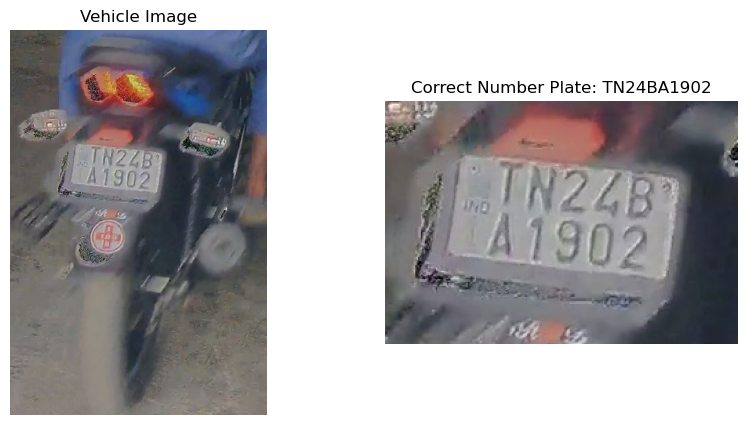

In [2]:
# Function to read the number plate using OCR
def get_number(number_plate):
    result = ocr.ocr(number_plate)
    if None in result:
        return "UNKNOWN"
    if len(result) == 0 or len(result[0]) < 2:
        return "UNKNOWN"
    number_plate_text = result[0][0][1][0] + result[0][1][1][0]
    number_plate_text = re.sub(r'[^a-zA-Z0-9]', '', number_plate_text)
    if len(number_plate_text) == 10 or len(number_plate_text) == 9:
        return number_plate_text
    return "UNKNOWN"

import matplotlib.pyplot as plt
from ppocr.utils.logging import get_logger
import logging
logger = get_logger()
logger.setLevel(logging.ERROR)

dict_int_to_char={'0':"O",'1':"I",'2':"Z",'3':"B",'4':"A",'5':"S",'6':"G",'7':"T",'8':"B",'9':"G"}
dict_char_to_int={'O':"0",'I':"1",'Z':"2",'B':"3",'A':"4",'S':"5",'G':"6",'T':"7",'B':"8",'G':"9"}

def correct_number_plate(number):
    # check the following conditions
        # 1. Number plate should have atleast 9 characters and atmost 10 characters
        # 2. first 2 characters should be alphabets
        # 3. next 2 characters should be digits
        # 4. last 4 characters should be digits
        # 5. remaining characters should be alphabets
    if number[:2].isalpha() and number[2:4].isdigit() and number[-4:].isdigit() and number[4:-4].isalpha() and len(number) >= 9 and len(number) <= 10:
        return number
    else:
        # correct the number plate
        number_list = list(number)
        length = len(number)
        changes = 0
        if length == 10:
            if not number[:2].isalpha():
                if number[0] in dict_int_to_char:
                    number_list[0] = dict_int_to_char[number[0]]
                    changes += 1
                if number[1] in dict_int_to_char:
                    number_list[1] = dict_int_to_char[number[1]]
                    changes += 1
            if not number[2:4].isdigit():
                if number[2] in dict_char_to_int:
                    number_list[2] = dict_char_to_int[number[2]]
                    changes += 1

                if number[3] in dict_char_to_int:
                    number_list[3] = dict_char_to_int[number[3]]
                    changes += 1

            if not number[4:6].isalpha():
                if number[4] in dict_int_to_char:
                    number_list[4] = dict_int_to_char[number[4]]
                    changes += 1
                if number[5] in dict_int_to_char:
                    number_list[5] = dict_int_to_char[number[5]]
                    changes += 1
            if not number[-4:].isdigit():
                if number[-4] in dict_char_to_int:
                    number_list[-4] = dict_char_to_int[number[-4]]
                    changes += 1
                if number[-3] in dict_char_to_int:
                    number_list[-3] = dict_char_to_int[number[-3]]
                    changes += 1
                if number[-2] in dict_char_to_int:
                    number_list[-2] = dict_char_to_int[number[-2]]
                    changes += 1
                if number[-1] in dict_char_to_int:
                    number_list[-1] = dict_char_to_int[number[-1]]
                    changes += 1
        elif length == 9:
            if not number[:2].isalpha():
                if number[0] in dict_int_to_char:
                    number_list[0] = dict_int_to_char[number[0]]
                    changes += 1
                if number[1] in dict_int_to_char:
                    number_list[1] = dict_int_to_char[number[1]]
                    changes += 1
            if not number[2:4].isdigit():
                if number[2] in dict_char_to_int:
                    number_list[2] = dict_char_to_int[number[2]]
                    changes += 1
                if number[3] in dict_char_to_int:
                    number_list[3] = dict_char_to_int[number[3]]
                    changes += 1
            if not number[4].isalpha():
                if number[4] in dict_int_to_char:
                    number_list[4] = dict_int_to_char[number[4]]
                    changes += 1
            if not number[-4:].isdigit():
                if number[-4] in dict_char_to_int:
                    number_list[-4] = dict_char_to_int[number[-4]]
                    changes += 1
                if number[-3] in dict_char_to_int:
                    number_list[-3] = dict_char_to_int[number[-3]]
                    changes += 1
                if number[-2] in dict_char_to_int:
                    number_list[-2] = dict_char_to_int[number[-2]]
                    changes += 1
                if number[-1] in dict_char_to_int:
                    number_list[-1] = dict_char_to_int[number[-1]]
                    changes += 1
        return "".join(number_list) , changes

path="detections/6"

def process_images(path,padding=30):
    predictions = []
    tracking_id=path.split("//")[-1]
    print(f"Tracking ID: {tracking_id}")
    total_files = len(os.listdir(path))
    print(f"Total Files: {total_files}")
    largest_orginal_image = None
    largest_orginal_image_area = 0
    largest_license_plate = None
    largest_license_plate_area = 0
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(path, file))
            # calculate the area of the image
            area = image.shape[0]*image.shape[1]
            if area > largest_orginal_image_area:
                largest_orginal_image_area = area
                largest_orginal_image = image

            results = number_plate_model.predict(image,verbose=False)[0]
            detections = sv.Detections.from_ultralytics(results)
            detections = detections.with_nms(0.5)
            if len(detections)>0:
                # crop the detected number plate
                x1,y1,x2,y2=detections.xyxy[0]
                x1=int(x1)
                y1=int(y1)
                x2=int(x2)
                y2=int(y2)
                # add some padding to the bounding box
                padding = padding
                x1 = max(0, x1-padding)
                y1 = max(0, y1-padding)
                x2 = min(image.shape[1], x2+padding)
                y2 = min(image.shape[0], y2+padding)
                number_plate = image[y1:y2,x1:x2]
                # calculate the area of the number plate
                area = number_plate.shape[0]*number_plate.shape[1]
                if area > largest_license_plate_area:
                    largest_license_plate_area = area
                    largest_license_plate = number_plate
                number = get_number(number_plate)
                if number[:2].isalpha() and number[2:4].isdigit() and number[-4:].isdigit() and number[4:-4].isalpha() and len(number) >= 9 and len(number) <= 10:
                    predictions.append((number,0))   
                else:
                    number,changes = correct_number_plate(number)
                    if number!="UNKNOWN" and number[:2].isalpha() and number[2:4].isdigit() and number[-4:].isdigit() and number[4:-4].isalpha() and len(number) >= 9 and len(number) <= 10:
                        predictions.append((number,changes))             
                #plt.imshow(cv2.cvtColor(number_plate, cv2.COLOR_BGR2RGB))
                #plt.title(f"Number Plate: {number}")
                #plt.axis('off')
                #plt.show()
    # most repeated number plate is the correct number
    if len(predictions) == 0:
        return  "UNKNOWN",largest_orginal_image, None
    elif len(predictions) == 1:
        return predictions[0] , largest_orginal_image, largest_license_plate
    else:
        # sort the predictions based on the least number of changes
        predictions = sorted(predictions,key=lambda x:x[1])
        return predictions[0][0] , largest_orginal_image, largest_license_plate

correct_number,vehicle,plate = process_images(path)
# plot the vehicle image and the number plate using subplot
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(cv2.cvtColor(vehicle, cv2.COLOR_BGR2RGB))
ax[0].set_title("Vehicle Image")
ax[0].axis('off')
if plate is not None:
    ax[1].imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Number Plate: {correct_number}")
    ax[1].axis('off')
plt.title(f"Correct Number Plate: {correct_number}")
plt.show()


In [3]:
import os
import pandas as pd
import time
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image as ExcelImage
import cv2

EXCEL_PATH = 'vehicle_data_with_images.xlsx'
IMAGE_DIR = 'temp_images/'

def save_images_to_disk(vehicle_image, license_plate_image, tracking_id):
    if " " in tracking_id:
        tracking_id = tracking_id.replace(" ", "_")
    """Save vehicle and license plate images temporarily, return their paths"""
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)

    vehicle_image_path = os.path.join(IMAGE_DIR, f'{tracking_id}_vehicle.jpg')
    license_plate_image_path = os.path.join(IMAGE_DIR, f'{tracking_id}_license_plate.jpg')

    if vehicle_image is not None:
        cv2.imwrite(vehicle_image_path, vehicle_image)
        # check if the image is saved
        if not os.path.exists(vehicle_image_path):
            print(f"Error: Vehicle image not saved to {vehicle_image_path}")

    if license_plate_image is not None:
        cv2.imwrite(license_plate_image_path, license_plate_image)
        # check if the image is saved
        if not os.path.exists(license_plate_image_path):
            print(f"Error: License plate image not saved to {license_plate_image_path}")

    return vehicle_image_path, license_plate_image_path
def add_images_to_excel(excel_writer, ws, ocr_output, vehicle_image_path, license_plate_image_path, date, time_of_arrival):
    """Embed images, date, time, and OCR output into an Excel sheet."""
    # Determine the next available row
    next_row = ws.max_row + 1

    # Insert Date and Time
    ws.cell(row=next_row, column=1).value = date
    ws.cell(row=next_row, column=2).value = time_of_arrival

    # Insert OCR output in the third column
    ws.cell(row=next_row, column=3).value = ocr_output

    # Embed vehicle image in the fourth column
    if vehicle_image_path and os.path.exists(vehicle_image_path):
        vehicle_img = ExcelImage(vehicle_image_path)
        vehicle_img.width = 100  # Resize image
        vehicle_img.height = 100
        ws.add_image(vehicle_img, f'D{next_row}')  # Adjust image position

    # Embed license plate image in the fifth column
    if license_plate_image_path and os.path.exists(license_plate_image_path):
        license_img = ExcelImage(license_plate_image_path)
        license_img.width = 100  # Resize image
        license_img.height = 100
        ws.add_image(license_img, f'E{next_row}')  # Adjust image position


    # Save the Excel file
    excel_writer.save(EXCEL_PATH)
    print(f"Data added to Excel at row {next_row}")

def save_to_excel(ocr_output, vehicle_image_path, license_plate_image_path, date, time_of_arrival, retry_attempts=5, wait_time=10):
    """Save the OCR output, date, time, and image paths to an Excel file."""
    for attempt in range(retry_attempts):
        try:
            if not os.path.exists(EXCEL_PATH):
                # Create a new Excel workbook if it doesn't exist
                wb = Workbook()
                ws = wb.active
                ws.title = "Vehicle Data"
                ws.append(["Date", "Time", "OCR Output", "Vehicle Image", "License Plate Image"])
                wb.save(EXCEL_PATH)
                print(f"Excel file created with headers on attempt {attempt + 1}")

            # Load the existing workbook
            wb = load_workbook(EXCEL_PATH)
            ws = wb.active

            # Add the OCR output, images, and date/time
            add_images_to_excel(wb, ws, ocr_output, vehicle_image_path, license_plate_image_path, date, time_of_arrival)
            break  # Exit the loop if successful
        except PermissionError:
            print(f"Excel file is open. Retrying in {wait_time} seconds... ({attempt + 1}/{retry_attempts})")
            time.sleep(wait_time)
        except Exception as e:
            print(f"An error occurred: {e}")
            break  # Exit if another error occurs


def process_images(path, padding=30):
    predictions = []
    tracking_id = path.split("//")[-1]
    print(f"Tracking ID: {tracking_id}")
    total_files = len(os.listdir(path))
    print(f"Total Files: {total_files}")
    
    largest_original_image = None
    largest_original_image_area = 0
    largest_license_plate = None
    largest_license_plate_area = 0

    for file in os.listdir(path):
        if file.endswith(".jpg"):
            date,t, _ = file.split("_")
            t=t.replace("-",":")
            image = cv2.imread(os.path.join(path, file))
            area = image.shape[0] * image.shape[1]
            if area > largest_original_image_area:
                largest_original_image_area = area
                largest_original_image = image

            results = number_plate_model.predict(image, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(results)
            detections = detections.with_nms(0.5)
            if len(detections) > 0:
                # Crop the detected number plate
                x1, y1, x2, y2 = detections.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # Add padding to the bounding box
                x1, y1 = max(0, x1 - padding), max(0, y1 - padding)
                x2, y2 = min(image.shape[1], x2 + padding), min(image.shape[0], y2 + padding)

                number_plate = image[y1:y2, x1:x2]
                area = number_plate.shape[0] * number_plate.shape[1]
                if area > largest_license_plate_area:
                    largest_license_plate_area = area
                    largest_license_plate = number_plate

                # OCR processing
                number = get_number(number_plate)
                if number[:2].isalpha() and number[2:4].isdigit() and number[-4:].isdigit() and number[4:-4].isalpha() and len(number) >= 9 and len(number) <= 10:
                    predictions.append((number, 0))
                else:
                    number, changes = correct_number_plate(number)
                    if number != "UNKNOWN" and number[:2].isalpha() and number[2:4].isdigit() and number[-4:].isdigit() and number[4:-4].isalpha() and len(number) >= 9 and len(number) <= 10:
                        predictions.append((number, changes))

    # Return the most confident prediction
    if len(predictions) == 0:
        return "UNKNOWN", largest_original_image, None
    elif len(predictions) == 1:
        return predictions[0], largest_original_image, largest_license_plate
    else:
        predictions = sorted(predictions, key=lambda x: x[1])
        return predictions[0][0], largest_original_image, largest_license_plate, date, t


# Example usage after processing
ocr_output, vehicle_image, license_plate_image,date,time_ = process_images('detections/6')

if vehicle_image is not None and license_plate_image is not None:
    vehicle_image_path, license_plate_image_path = save_images_to_disk(vehicle_image, license_plate_image, '6')
    save_to_excel(ocr_output, vehicle_image_path, license_plate_image_path, date, time_)
        # delete the temporary images
    if os.path.exists(vehicle_image_path):
        os.remove(vehicle_image_path)
    if os.path.exists(license_plate_image_path):
        os.remove(license_plate_image_path)
else:
    print("No valid images to save.")


Tracking ID: detections/6
Total Files: 40
Data added to Excel at row 3


In [4]:
import os
import time
import cv2
import numpy as np
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

# Your process_images function here (make sure it's defined properly)
# from your_module import process_images

class NewFolderHandler(FileSystemEventHandler):
    def __init__(self, base_path, wait_time=5, max_retries=10, grace_period=5):
        self.base_path = base_path
        self.wait_time = wait_time  # Time to wait before retrying
        self.max_retries = max_retries  # Number of retries before giving up
        self.grace_period = grace_period  # Wait time to allow file to fully be available

    def on_created(self, event):
        # When a new directory is created
        if event.is_directory:
            new_folder = event.src_path
            print(f"New folder detected: {new_folder}")
            # Wait until the folder contains files before processing
            success = self.wait_for_files(new_folder)
            if success:
                time.sleep(self.grace_period)  # Allow time for files to stabilize
                # Process images inside the new folder
                result = process_images_with_retry(new_folder)
                # save the result to excel
                if result is not None:
                    print("Saving result to Excel...")
                    ocr_output, vehicle_image, license_plate_image, date, time_ = result
                    tracking_id = new_folder.split("/")[-1]
                    if vehicle_image is not None and license_plate_image is not None:
                        vehicle_image_path, license_plate_image_path = save_images_to_disk(vehicle_image, license_plate_image, tracking_id)
                        print(vehicle_image_path, license_plate_image_path)
                        save_to_excel(ocr_output, vehicle_image_path, license_plate_image_path, date, time_)
                        print("Data saved to Excel.")
                    else:
                        vehicle_image_path, license_plate_image_path = save_images_to_disk(vehicle_image, np.zeros((100, 100, 3), dtype=np.uint8), tracking_id)
                        save_to_excel(ocr_output, vehicle_image_path, license_plate_image_path, date, time_)
                        print("Data saved to Excel.")
            else:
                print(f"Failed to process {new_folder}: No files detected after waiting.")

    def wait_for_files(self, folder):
        """Wait for files to appear in the folder before processing"""
        retries = 0
        while retries < self.max_retries:
            files = os.listdir(folder)
            if len(files) > 0:
                print(f"Files detected in {folder}. Proceeding with processing.")
                return True
            else:
                print(f"No files yet in {folder}. Retrying ({retries + 1}/{self.max_retries})...")
                time.sleep(self.wait_time)
                retries += 1
        return False

def process_images_with_retry(folder, max_retries=5):
    """Wrapper to retry process_images in case of permission errors"""
    retries = 0
    while retries < max_retries:
        try:
            result = process_images(folder)
            return result
        except PermissionError as e:
            print(f"Permission error when accessing files in {folder}: {e}. Retrying ({retries + 1}/{max_retries})...")
            time.sleep(2)  # Wait a bit before retrying
            retries += 1
    return "Failed to process due to PermissionError."

def monitor_directory(base_path):
    event_handler = NewFolderHandler(base_path)
    observer = Observer()
    observer.schedule(event_handler, path=base_path, recursive=False)
    observer.start()

    print(f"Monitoring folder: {base_path} for new folders...")
    try:
        while True:
            time.sleep(1)  # keep the script running
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

if __name__ == "__main__":
    path_to_watch = "detections/"
    if not os.path.exists(path_to_watch):
        print(f"The folder '{path_to_watch}' does not exist.")
    else:
        monitor_directory(path_to_watch)


Monitoring folder: detections/ for new folders...
New folder detected: detections/1
No files yet in detections/1. Retrying (1/10)...
Files detected in detections/1. Proceeding with processing.
Tracking ID: detections/1
Total Files: 59
Saving result to Excel...
temp_images/1_vehicle.jpg temp_images/1_license_plate.jpg
Data added to Excel at row 3
Data saved to Excel.
New folder detected: detections/2
No files yet in detections/2. Retrying (1/10)...
Files detected in detections/2. Proceeding with processing.
Tracking ID: detections/2
Total Files: 23
Saving result to Excel...
temp_images/2_vehicle.jpg temp_images/2_license_plate.jpg
Excel file is open. Retrying in 10 seconds... (1/5)
Data added to Excel at row 4
Data saved to Excel.
New folder detected: detections/6
No files yet in detections/6. Retrying (1/10)...
Files detected in detections/6. Proceeding with processing.
Tracking ID: detections/6
Total Files: 12
Saving result to Excel...
temp_images/6_vehicle.jpg temp_images/6_license_p

Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\Users\marin\anaconda3\envs\roboflow\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\marin\anaconda3\envs\roboflow\lib\site-packages\watchdog\observers\api.py", line 212, in run
    self.dispatch_events(self.event_queue)
  File "c:\Users\marin\anaconda3\envs\roboflow\lib\site-packages\watchdog\observers\api.py", line 386, in dispatch_events
    handler.dispatch(event)
  File "c:\Users\marin\anaconda3\envs\roboflow\lib\site-packages\watchdog\events.py", line 218, in dispatch
    {
  File "C:\Users\marin\AppData\Local\Temp\ipykernel_7292\4227678266.py", line 32, in on_created
ValueError: not enough values to unpack (expected 5, got 3)


Saving result to Excel...
